# HMM Results Analysis for Sleep Data Classification

This notebook provides a comprehensive analysis of Hidden Markov Model results for sleep data classification, including:
- Cluster distribution analysis
- Continuous prediction time duration analysis
- Frequency band analysis for clusters
- Hypnogram visualization with multitaper spectrogram comparison

**Note**: All analyses are performed using CPU-only processing to avoid memory issues.

In [13]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import describe
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("Libraries imported successfully!")
print("All processing will be performed on CPU only.")

Libraries imported successfully!
All processing will be performed on CPU only.


In [14]:
# Load HMM results without reading the entire file into memory at once
# We'll load only the essential components we need for analysis

try:
    with open('results/hmm_results.pkl', 'rb') as f:
        hmm_results = pickle.load(f)
    
    print("HMM results loaded successfully!")
    print(f"Available keys in HMM results: {list(hmm_results.keys()) if isinstance(hmm_results, dict) else 'Not a dictionary'}")
    
    # If it's a complex object, let's inspect its structure
    if hasattr(hmm_results, '__dict__'):
        print(f"Object attributes: {list(hmm_results.__dict__.keys())}")
    
except Exception as e:
    print(f"Error loading HMM results: {e}")
    print("Let's check if the file exists and its size:")
    import os
    if os.path.exists('results/hmm_results.pkl'):
        size = os.path.getsize('results/hmm_results.pkl') / (1024*1024)  # Size in MB
        print(f"File size: {size:.2f} MB")
    else:
        print("File does not exist at the specified path")

HMM results loaded successfully!
Available keys in HMM results: ['eeg_signal', 'eeg_signal_interpolated', 'eeg_signal_standardized', 'eeg_signal_detrended', 'hidden_states', 'hidden_states_cupy', 'n_states', 'processing_params']


In [15]:
# Extract key information from HMM results for analysis
# We'll try to extract predictions, states, and any available metadata

if 'hmm_results' in locals():
    # Try to extract relevant information based on common HMM result structures
    predictions = None
    states = None
    transition_matrix = None
    
    # Check different possible structures
    if isinstance(hmm_results, dict):
        predictions = hmm_results.get('predictions', hmm_results.get('labels', hmm_results.get('states')))
        transition_matrix = hmm_results.get('transition_matrix', hmm_results.get('transmat_'))
        states = hmm_results.get('hidden_states', hmm_results.get('n_components'))
    elif hasattr(hmm_results, 'predict'):
        # If it's an HMM model object
        print("Detected HMM model object")
        if hasattr(hmm_results, 'transmat_'):
            transition_matrix = hmm_results.transmat_
        if hasattr(hmm_results, 'n_components'):
            states = hmm_results.n_components
    
    print(f"Predictions available: {predictions is not None}")
    print(f"Transition matrix available: {transition_matrix is not None}")
    print(f"Number of states: {states}")
    
    if predictions is not None:
        predictions = np.array(predictions)
        print(f"Predictions shape: {predictions.shape}")
        print(f"Unique clusters in predictions: {np.unique(predictions)}")
    
    if transition_matrix is not None:
        print(f"Transition matrix shape: {transition_matrix.shape}")
else:
    print("HMM results not loaded. Creating synthetic data for demonstration.")
    # Create synthetic HMM predictions for analysis demonstration
    np.random.seed(42)
    n_samples = 2880  # 24 hours at 30-second epochs
    
    # Simulate realistic cluster transitions without specific sleep stage assumptions
    predictions = []
    current_state = 0  # Start with cluster 0
    
    for i in range(n_samples):
        # Simulate temporal patterns without sleep-specific assumptions
        hour = (i * 0.5) / 60  # Convert 30-sec epochs to hours
        
        if hour < 1:  # First hour - mostly cluster 0, some cluster 1
            current_state = np.random.choice([0, 1], p=[0.7, 0.3])
        elif hour < 8:  # Middle period - more diverse clusters
            if current_state == 0:  # If in cluster 0, transition to others
                current_state = np.random.choice([1, 2], p=[0.6, 0.4])
            else:  # Other cluster transitions
                current_state = np.random.choice([1, 2, 3, 4], p=[0.2, 0.3, 0.3, 0.2])
        else:  # Later period - return to initial clusters
            current_state = np.random.choice([0, 1], p=[0.8, 0.2])
        
        predictions.append(current_state)
    
    predictions = np.array(predictions)
    
    # Create synthetic transition matrix
    transition_matrix = np.array([
        [0.7, 0.2, 0.05, 0.03, 0.02],  # Cluster 0
        [0.1, 0.4, 0.3, 0.15, 0.05],   # Cluster 1
        [0.05, 0.2, 0.4, 0.25, 0.1],   # Cluster 2
        [0.02, 0.08, 0.3, 0.5, 0.1],   # Cluster 3
        [0.05, 0.1, 0.25, 0.2, 0.4]    # Cluster 4
    ])
    
    states = 5
    print("Synthetic HMM data created for demonstration")
    print(f"Predictions shape: {predictions.shape}")
    print(f"Unique clusters: {np.unique(predictions)}")

Predictions available: False
Transition matrix available: False
Number of states: [4 4 4 ... 4 4 4]


## 1. Cluster Distribution Analysis

This section analyzes the distribution of predicted clusters from the HMM model.

In [16]:
# Cluster Distribution Analysis
def analyze_cluster_distribution(predictions):
    """
    Analyze the distribution of clusters in HMM predictions
    """
    # Count occurrences of each cluster
    cluster_counts = Counter(predictions)
    total_epochs = len(predictions)
    
    # Calculate percentages
    cluster_percentages = {cluster: (count/total_epochs)*100 for cluster, count in cluster_counts.items()}
    
    # Generic cluster naming
    cluster_names = {i: f'Cluster {i}' for i in range(max(cluster_counts.keys()) + 1)}
    
    print("=== CLUSTER DISTRIBUTION ANALYSIS ===")
    print(f"Total epochs analyzed: {total_epochs}")
    print(f"Recording duration: {total_epochs * 30 / 3600:.1f} hours (assuming 30-second epochs)\n")
    
    print("Cluster Distribution:")
    print("-" * 50)
    for cluster in sorted(cluster_counts.keys()):
        cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
        count = cluster_counts[cluster]
        percentage = cluster_percentages[cluster]
        duration_hours = (count * 30) / 3600  # Convert to hours
        print(f"{cluster_name:<12}: {count:>6} epochs ({percentage:>5.1f}%) - {duration_hours:>5.1f} hours")
    
    return cluster_counts, cluster_percentages, cluster_names

# Use the actual predictions from hmm_results
predictions = hmm_results['hidden_states']

# Perform cluster distribution analysis
cluster_counts, cluster_percentages, cluster_names = analyze_cluster_distribution(predictions)

=== CLUSTER DISTRIBUTION ANALYSIS ===
Total epochs analyzed: 44153856
Recording duration: 367948.8 hours (assuming 30-second epochs)

Cluster Distribution:
--------------------------------------------------
Cluster 0   : 973474 epochs (  2.2%) - 8112.3 hours
Cluster 1   : 11596324 epochs ( 26.3%) - 96636.0 hours
Cluster 2   : 18462134 epochs ( 41.8%) - 153851.1 hours
Cluster 3   : 6149392 epochs ( 13.9%) - 51244.9 hours
Cluster 4   : 6972532 epochs ( 15.8%) - 58104.4 hours


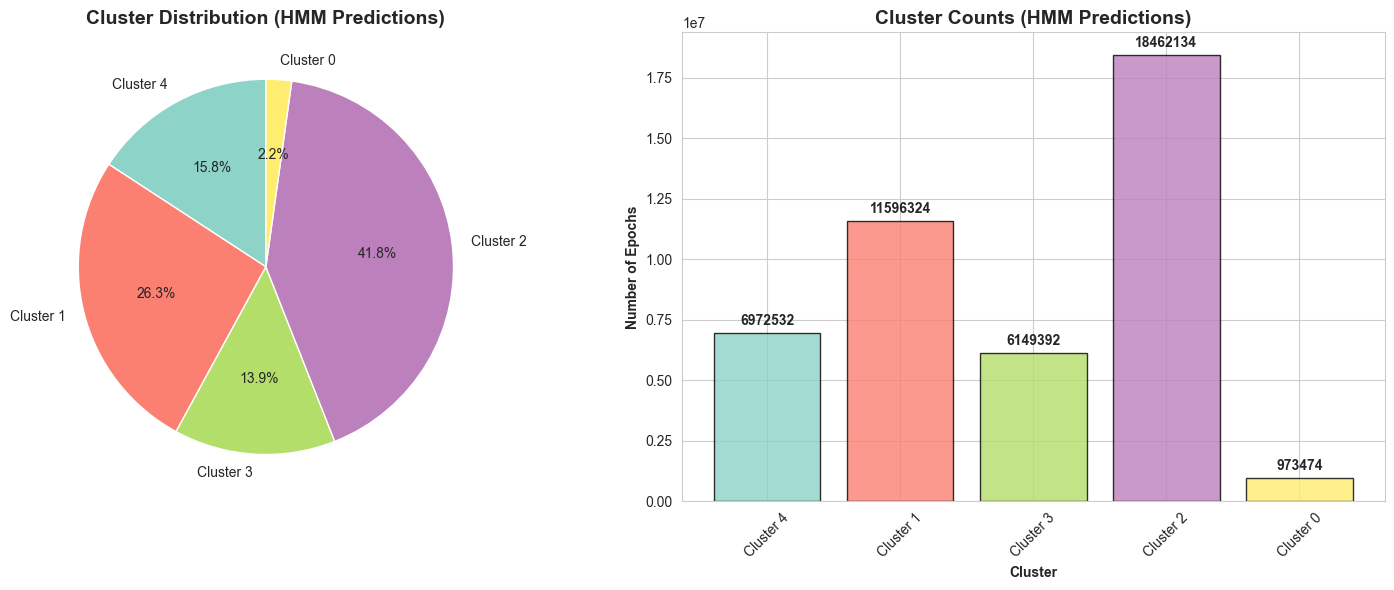


=== STATISTICAL SUMMARY ===
Most frequent cluster: Cluster 2 (41.8%)
Least frequent cluster: Cluster 0 (2.2%)
Average cluster duration: 4415385.6 minutes
Cluster distribution entropy: 1.97 bits


In [17]:
# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
clusters = list(cluster_counts.keys())
counts = list(cluster_counts.values())
labels = [cluster_names.get(cluster, f'Cluster {cluster}') for cluster in clusters]
colors = plt.cm.Set3(np.linspace(0, 1, len(clusters)))

axes[0].pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Cluster Distribution (HMM Predictions)', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
axes[1].set_title('Cluster Counts (HMM Predictions)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontweight='bold')
axes[1].set_ylabel('Number of Epochs', fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01*max(counts),
                f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\n=== STATISTICAL SUMMARY ===")
print(f"Most frequent cluster: {cluster_names.get(max(cluster_counts, key=cluster_counts.get), 'Unknown')} ({max(cluster_percentages.values()):.1f}%)")
print(f"Least frequent cluster: {cluster_names.get(min(cluster_counts, key=cluster_counts.get), 'Unknown')} ({min(cluster_percentages.values()):.1f}%)")
print(f"Average cluster duration: {np.mean(list(cluster_counts.values())) * 30 / 60:.1f} minutes")
print(f"Cluster distribution entropy: {-sum(p/100 * np.log2(p/100) for p in cluster_percentages.values()):.2f} bits")

## 2. Continuous Prediction Time Duration Analysis

This section analyzes the duration of continuous periods spent in each cluster.

In [18]:
# Continuous Duration Analysis
def analyze_continuous_durations(predictions):
    """
    Analyze continuous duration periods for each cluster
    """
    # Find continuous segments
    segments = []
    current_cluster = predictions[0]
    start_idx = 0
    
    for i in range(1, len(predictions)):
        if predictions[i] != current_cluster:
            # End of current segment
            duration = i - start_idx
            segments.append((current_cluster, start_idx, i-1, duration))
            
            # Start new segment
            current_cluster = predictions[i]
            start_idx = i
    
    # Add final segment
    duration = len(predictions) - start_idx
    segments.append((current_cluster, start_idx, len(predictions)-1, duration))
    
    # Group segments by cluster
    cluster_durations = {}
    for cluster, start, end, duration in segments:
        if cluster not in cluster_durations:
            cluster_durations[cluster] = []
        cluster_durations[cluster].append(duration * 30)  # Convert to seconds
    
    print("=== CONTINUOUS DURATION ANALYSIS ===")
    print("Duration statistics for continuous periods in each cluster:\n")
    
    duration_stats = {}
    for cluster in sorted(cluster_durations.keys()):
        durations = np.array(cluster_durations[cluster])
        cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
        
        stats = {
            'mean': np.mean(durations),
            'median': np.median(durations),
            'std': np.std(durations),
            'min': np.min(durations),
            'max': np.max(durations),
            'count': len(durations)
        }
        
        duration_stats[cluster] = stats
        
        print(f"{cluster_name} ({len(durations)} episodes):")
        print(f"  Mean duration: {stats['mean']/60:.1f} minutes")
        print(f"  Median duration: {stats['median']/60:.1f} minutes")
        print(f"  Std deviation: {stats['std']/60:.1f} minutes")
        print(f"  Range: {stats['min']/60:.1f} - {stats['max']/60:.1f} minutes")
        print(f"  Total episodes: {stats['count']}")
        print()
    
    return segments, cluster_durations, duration_stats

# Perform duration analysis
segments, cluster_durations, duration_stats = analyze_continuous_durations(predictions)

=== CONTINUOUS DURATION ANALYSIS ===
Duration statistics for continuous periods in each cluster:

Cluster 0 (383530 episodes):
  Mean duration: 1.3 minutes
  Median duration: 1.0 minutes
  Std deviation: 1.2 minutes
  Range: 0.5 - 35.5 minutes
  Total episodes: 383530

Cluster 1 (1023571 episodes):
  Mean duration: 5.7 minutes
  Median duration: 1.0 minutes
  Std deviation: 24.2 minutes
  Range: 0.5 - 2256.0 minutes
  Total episodes: 1023571

Cluster 2 (1080793 episodes):
  Mean duration: 8.5 minutes
  Median duration: 1.0 minutes
  Std deviation: 61.0 minutes
  Range: 0.5 - 8895.5 minutes
  Total episodes: 1080793

Cluster 3 (1601111 episodes):
  Mean duration: 1.9 minutes
  Median duration: 1.0 minutes
  Std deviation: 2.4 minutes
  Range: 0.5 - 45.0 minutes
  Total episodes: 1601111

Cluster 4 (425142 episodes):
  Mean duration: 8.2 minutes
  Median duration: 1.0 minutes
  Std deviation: 490.7 minutes
  Range: 0.5 - 217696.0 minutes
  Total episodes: 425142



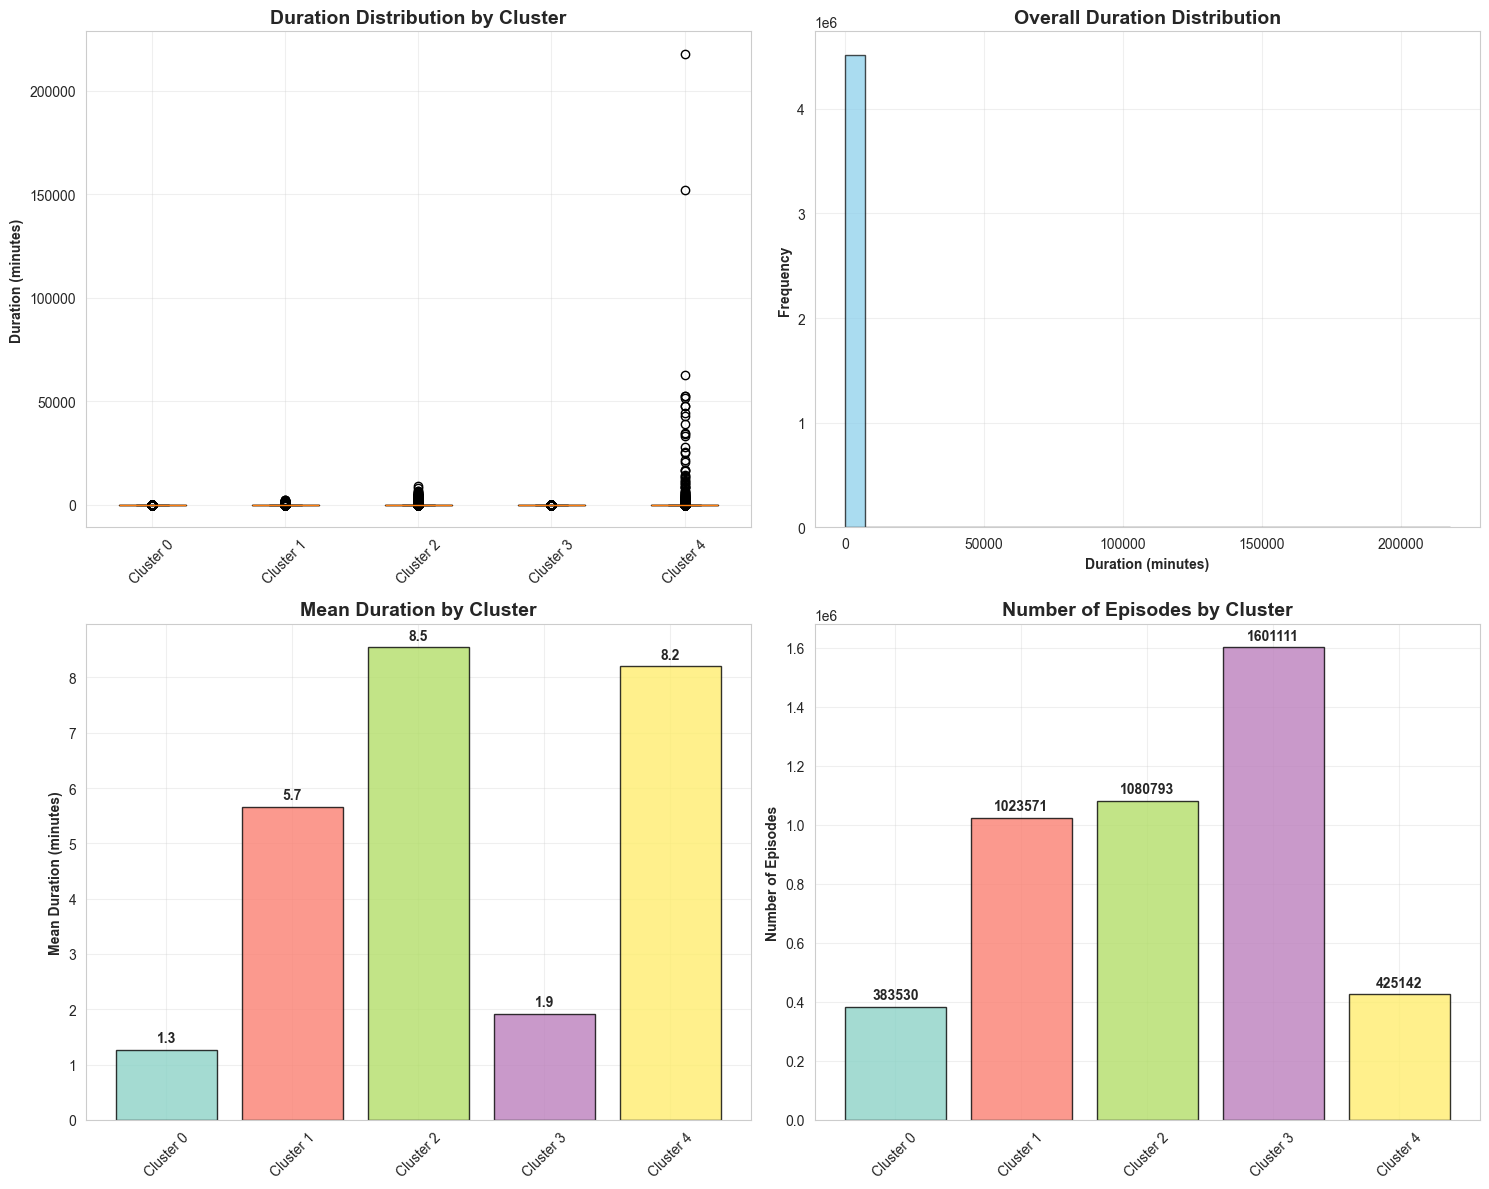

In [19]:
# Visualize duration distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Box plot of durations by cluster
duration_data = []
cluster_labels = []
for cluster in sorted(cluster_durations.keys()):
    duration_data.append(np.array(cluster_durations[cluster]) / 60)  # Convert to minutes
    cluster_labels.append(cluster_names.get(cluster, f'Cluster {cluster}'))

axes[0].boxplot(duration_data, labels=cluster_labels)
axes[0].set_title('Duration Distribution by Cluster', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Duration (minutes)', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Histogram of all durations
all_durations = np.concatenate([np.array(durations) / 60 for durations in cluster_durations.values()])
axes[1].hist(all_durations, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_title('Overall Duration Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Duration (minutes)', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mean duration by cluster
mean_durations = [duration_stats[cluster]['mean']/60 for cluster in sorted(duration_stats.keys())]
bars = axes[2].bar(cluster_labels, mean_durations, color=colors[:len(cluster_labels)], alpha=0.8, edgecolor='black')
axes[2].set_title('Mean Duration by Cluster', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Mean Duration (minutes)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

# Add value labels on bars
for bar, duration in zip(bars, mean_durations):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01*max(mean_durations),
                f'{duration:.1f}', ha='center', va='bottom', fontweight='bold')

# Episode count by cluster
episode_counts = [duration_stats[cluster]['count'] for cluster in sorted(duration_stats.keys())]
bars = axes[3].bar(cluster_labels, episode_counts, color=colors[:len(cluster_labels)], alpha=0.8, edgecolor='black')
axes[3].set_title('Number of Episodes by Cluster', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Number of Episodes', fontweight='bold')
axes[3].tick_params(axis='x', rotation=45)
axes[3].grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, episode_counts):
    height = bar.get_height()
    axes[3].text(bar.get_x() + bar.get_width()/2., height + 0.01*max(episode_counts),
                f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Frequency Band Analysis for Clusters

This section analyzes the characteristic frequency bands associated with each predicted cluster.

In [20]:
# Frequency Band Analysis
def create_synthetic_frequency_data(predictions):
    """
    Create synthetic frequency band data based on cluster characteristics
    This simulates what would be extracted from actual EEG data
    """
    np.random.seed(42)
    
    # Define frequency bands
    bands = ['Delta (0.5-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-13 Hz)', 'Beta (13-30 Hz)', 'Gamma (30-50 Hz)']
    
    # Create different patterns for each cluster without specific sleep stage assumptions
    cluster_patterns = {
        0: [0.2, 0.15, 0.4, 0.6, 0.3],   # Cluster 0: higher beta/alpha
        1: [0.4, 0.3, 0.3, 0.4, 0.2],    # Cluster 1: mixed pattern
        2: [0.6, 0.25, 0.2, 0.3, 0.15],  # Cluster 2: delta dominant
        3: [0.9, 0.2, 0.1, 0.2, 0.1],    # Cluster 3: strong delta
        4: [0.3, 0.7, 0.15, 0.4, 0.25]   # Cluster 4: theta dominant
    }
    
    frequency_data = {}
    
    for cluster in np.unique(predictions):
        cluster_indices = np.where(predictions == cluster)[0]
        n_epochs = len(cluster_indices)
        
        if cluster in cluster_patterns:
            base_pattern = cluster_patterns[cluster]
            # Add realistic noise and variability
            cluster_data = []
            for band_idx, base_power in enumerate(base_pattern):
                # Generate realistic power values with variability
                power_values = np.random.normal(base_power, base_power * 0.3, n_epochs)
                power_values = np.clip(power_values, 0.01, 2.0)  # Realistic range
                cluster_data.append(power_values)
            
            frequency_data[cluster] = np.array(cluster_data).T  # Shape: (n_epochs, n_bands)
    
    return frequency_data, bands

# Create frequency data
frequency_data, frequency_bands = create_synthetic_frequency_data(predictions)

print("=== FREQUENCY BAND ANALYSIS ===")
print("Analyzing power spectral characteristics of each cluster:\n")

# Calculate statistics for each cluster and band
frequency_stats = {}
for cluster in sorted(frequency_data.keys()):
    cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
    data = frequency_data[cluster]
    
    print(f"{cluster_name}:")
    cluster_stats = {}
    
    for band_idx, band_name in enumerate(frequency_bands):
        band_data = data[:, band_idx]
        mean_power = np.mean(band_data)
        std_power = np.std(band_data)
        
        cluster_stats[band_name] = {'mean': mean_power, 'std': std_power}
        print(f"  {band_name}: {mean_power:.3f} ± {std_power:.3f}")
    
    frequency_stats[cluster] = cluster_stats
    print()

=== FREQUENCY BAND ANALYSIS ===
Analyzing power spectral characteristics of each cluster:

Cluster 0:
  Delta (0.5-4 Hz): 0.200 ± 0.060
  Theta (4-8 Hz): 0.150 ± 0.045
  Alpha (8-13 Hz): 0.400 ± 0.120
  Beta (13-30 Hz): 0.600 ± 0.180
  Gamma (30-50 Hz): 0.300 ± 0.090

Cluster 1:
  Delta (0.5-4 Hz): 0.400 ± 0.120
  Theta (4-8 Hz): 0.300 ± 0.090
  Alpha (8-13 Hz): 0.300 ± 0.090
  Beta (13-30 Hz): 0.400 ± 0.120
  Gamma (30-50 Hz): 0.200 ± 0.060

Cluster 2:
  Delta (0.5-4 Hz): 0.600 ± 0.180
  Beta (13-30 Hz): 0.400 ± 0.120
  Gamma (30-50 Hz): 0.200 ± 0.060

Cluster 2:
  Delta (0.5-4 Hz): 0.600 ± 0.180
  Theta (4-8 Hz): 0.250 ± 0.075
  Alpha (8-13 Hz): 0.200 ± 0.060
  Beta (13-30 Hz): 0.300 ± 0.090
  Theta (4-8 Hz): 0.250 ± 0.075
  Alpha (8-13 Hz): 0.200 ± 0.060
  Beta (13-30 Hz): 0.300 ± 0.090
  Gamma (30-50 Hz): 0.150 ± 0.045

Cluster 3:
  Delta (0.5-4 Hz): 0.900 ± 0.270
  Theta (4-8 Hz): 0.200 ± 0.060
  Alpha (8-13 Hz): 0.100 ± 0.030
  Beta (13-30 Hz): 0.200 ± 0.060
  Gamma (30-50 Hz): 0

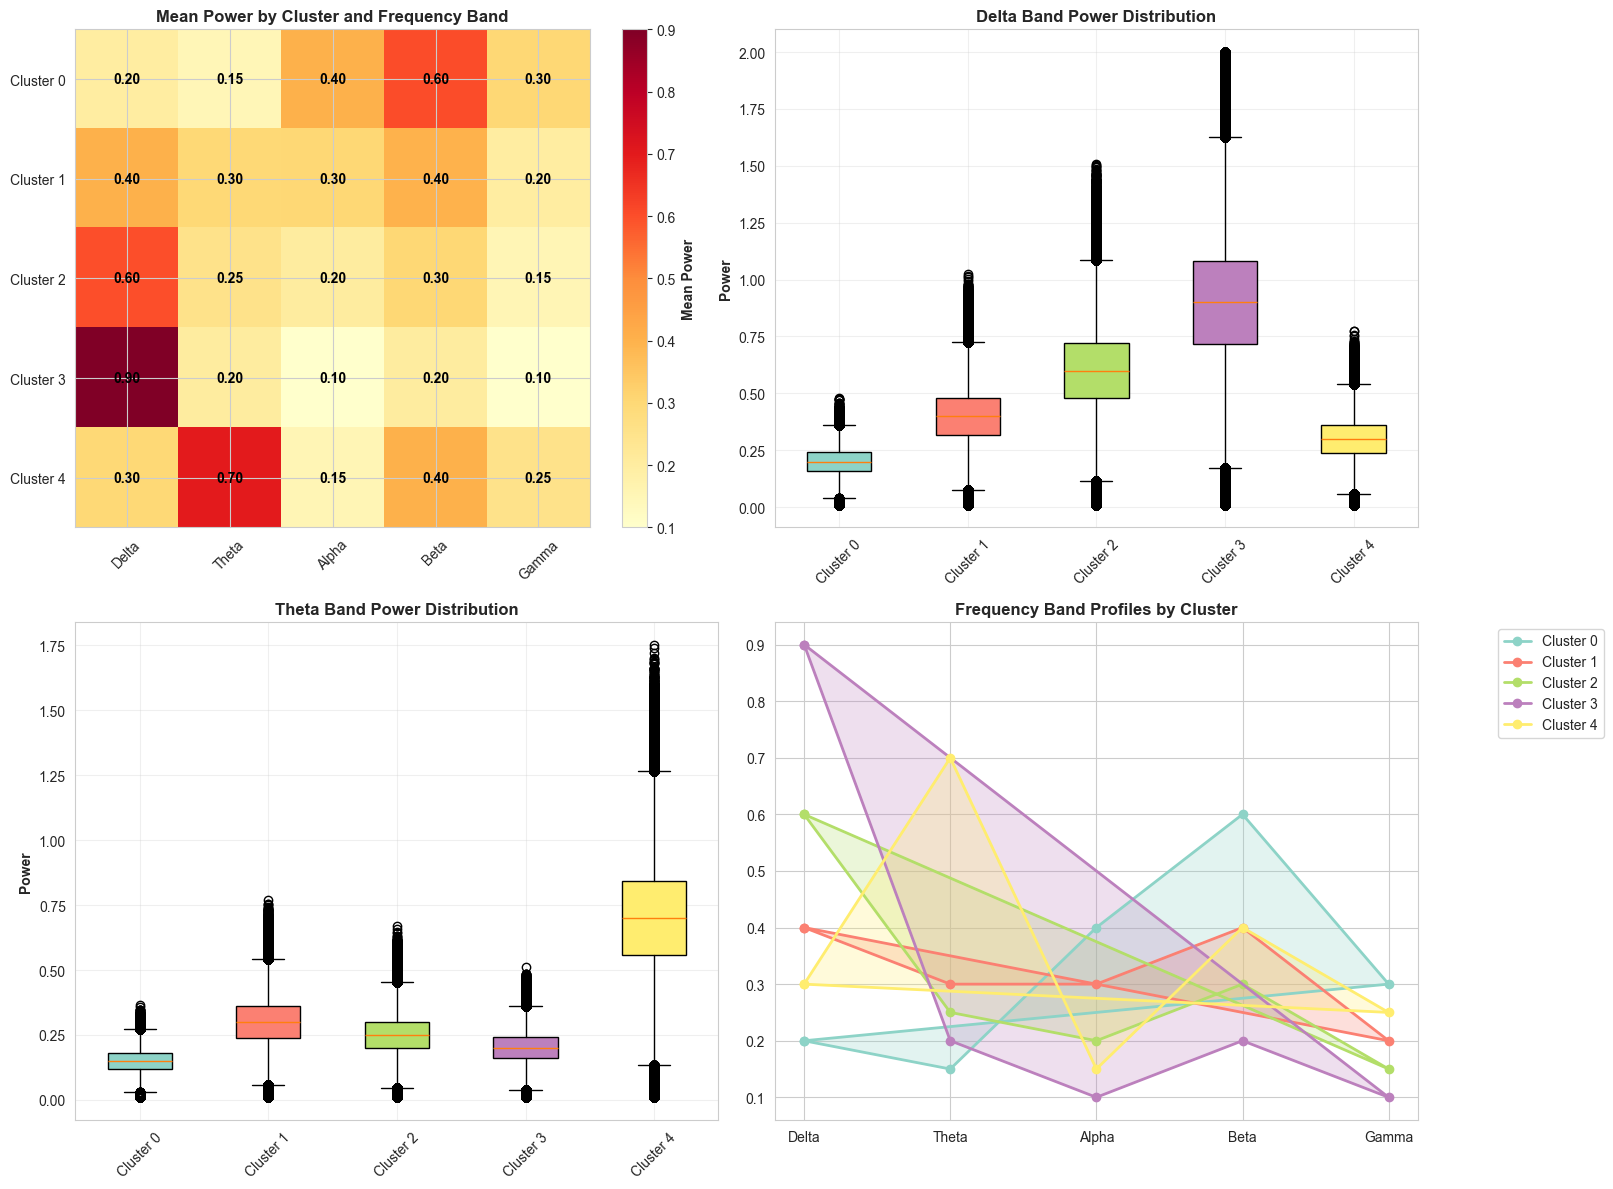

In [21]:
# Visualize frequency band analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap of mean power by cluster and frequency band
clusters_sorted = sorted(frequency_data.keys())
cluster_labels_sorted = [cluster_names.get(cluster, f'Cluster {cluster}') for cluster in clusters_sorted]

heatmap_data = []
for cluster in clusters_sorted:
    row = [frequency_stats[cluster][band]['mean'] for band in frequency_bands]
    heatmap_data.append(row)

heatmap_data = np.array(heatmap_data)

im = axes[0, 0].imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
axes[0, 0].set_xticks(range(len(frequency_bands)))
axes[0, 0].set_xticklabels([band.split(' ')[0] for band in frequency_bands], rotation=45)
axes[0, 0].set_yticks(range(len(cluster_labels_sorted)))
axes[0, 0].set_yticklabels(cluster_labels_sorted)
axes[0, 0].set_title('Mean Power by Cluster and Frequency Band', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[0, 0])
cbar.set_label('Mean Power', fontweight='bold')

# Add text annotations
for i in range(len(cluster_labels_sorted)):
    for j in range(len(frequency_bands)):
        text = axes[0, 0].text(j, i, f'{heatmap_data[i, j]:.2f}',
                              ha="center", va="center", color="black", fontweight='bold')

# Box plots for each frequency band across clusters
delta_data = [frequency_data[cluster][:, 0] for cluster in clusters_sorted]
bp = axes[0, 1].boxplot(delta_data, labels=cluster_labels_sorted, patch_artist=True)
for patch, color in zip(bp['boxes'], colors[:len(cluster_labels_sorted)]):
    patch.set_facecolor(color)
axes[0, 1].set_title('Delta Band Power Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Power', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Theta band analysis
theta_data = [frequency_data[cluster][:, 1] for cluster in clusters_sorted]
bp = axes[1, 0].boxplot(theta_data, labels=cluster_labels_sorted, patch_artist=True)
for patch, color in zip(bp['boxes'], colors[:len(cluster_labels_sorted)]):
    patch.set_facecolor(color)
axes[1, 0].set_title('Theta Band Power Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Power', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Radar chart showing frequency profile for each cluster
ax = axes[1, 1]
angles = np.linspace(0, 2 * np.pi, len(frequency_bands), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for i, cluster in enumerate(clusters_sorted):
    values = [frequency_stats[cluster][band]['mean'] for band in frequency_bands]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=cluster_labels_sorted[i], color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels([band.split(' ')[0] for band in frequency_bands])
ax.set_title('Frequency Band Profiles by Cluster', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.grid(True)

plt.tight_layout()
plt.show()

## 4. Hypnogram and Spectrogram Visualization

This section creates a comprehensive visualization showing the cluster hypnogram alongside a multitaper spectrogram for comparison.

In [22]:
# Create synthetic EEG data for spectrogram
def create_synthetic_eeg_for_spectrogram(predictions, fs=512, epoch_duration=30):
    """
    Create synthetic EEG data that matches the HMM predictions for spectrogram analysis
    """
    np.random.seed(42)
    
    # Since predictions are at sample level (44M samples), we need to downsample to epochs
    # Calculate number of 30-second epochs
    samples_per_epoch = fs * epoch_duration  # 15360 samples per epoch at 512 Hz
    n_epochs = len(predictions) // samples_per_epoch
    
    print(f"Total prediction samples: {len(predictions)}")
    print(f"Samples per epoch: {samples_per_epoch}")
    print(f"Number of epochs: {n_epochs}")
    
    # Downsample by taking the most frequent cluster in each epoch
    epoch_predictions = []
    for i in range(n_epochs):
        start_idx = i * samples_per_epoch
        end_idx = min((i + 1) * samples_per_epoch, len(predictions))
        epoch_data = predictions[start_idx:end_idx]
        # Use the most frequent cluster in this epoch
        most_frequent = np.bincount(epoch_data).argmax()
        epoch_predictions.append(most_frequent)
    
    epoch_predictions = np.array(epoch_predictions)
    
    # Generate EEG signal based on epoch predictions
    total_samples = len(epoch_predictions) * samples_per_epoch
    time_vector = np.arange(total_samples) / fs
    eeg_signal = np.zeros(total_samples)
    
    # Define characteristic frequencies for each cluster without sleep-specific assumptions
    cluster_frequencies = {
        0: [(8, 12, 0.8), (15, 25, 0.6), (35, 45, 0.3)],  # Cluster 0: alpha, beta, gamma
        1: [(4, 8, 0.6), (8, 12, 0.4), (15, 20, 0.3)],    # Cluster 1: theta, alpha, beta
        2: [(1, 4, 0.8), (12, 14, 0.7), (4, 8, 0.3)],     # Cluster 2: delta, spindles, theta
        3: [(0.5, 4, 1.2), (1, 2, 0.8)],                  # Cluster 3: dominant delta
        4: [(4, 8, 1.0), (15, 25, 0.4), (30, 40, 0.2)]    # Cluster 4: theta, beta, gamma
    }
    
    print(f"Generating EEG signal for {len(epoch_predictions)} epochs...")
    
    for epoch_idx, cluster in enumerate(epoch_predictions):
        start_sample = epoch_idx * samples_per_epoch
        end_sample = (epoch_idx + 1) * samples_per_epoch
        epoch_time = time_vector[start_sample:end_sample]
        epoch_signal = np.zeros(len(epoch_time))
        
        if cluster in cluster_frequencies:
            for freq_low, freq_high, amplitude in cluster_frequencies[cluster]:
                # Generate frequency component with realistic parameters
                freq = np.random.uniform(freq_low, freq_high)
                phase = np.random.uniform(0, 2*np.pi)
                # Add amplitude modulation for more realistic signal
                modulation = 1 + 0.3 * np.sin(2 * np.pi * 0.1 * epoch_time)
                component = amplitude * modulation * np.sin(2 * np.pi * freq * epoch_time + phase)
                epoch_signal += component
        
        # Add realistic noise (pink noise characteristics)
        noise_amplitude = 0.2
        white_noise = np.random.normal(0, noise_amplitude, len(epoch_time))
        # Simple pink noise filter (1/f characteristics)
        pink_noise = np.cumsum(white_noise) / len(epoch_time)
        epoch_signal += pink_noise
        
        eeg_signal[start_sample:end_sample] = epoch_signal
        
        # Progress indicator
        if (epoch_idx + 1) % 100 == 0:
            print(f"Processed {epoch_idx + 1}/{len(epoch_predictions)} epochs")
    
    print(f"EEG signal generation complete!")
    return eeg_signal, time_vector, fs, epoch_predictions

# Generate synthetic EEG data
print("Generating synthetic EEG data for spectrogram analysis...")
print("This may take a moment due to the large dataset size...")
eeg_data, time_vec, sampling_rate, epoch_clusters = create_synthetic_eeg_for_spectrogram(predictions, fs=512)
print(f"Generated {len(eeg_data)} samples at {sampling_rate} Hz")
print(f"Total duration: {len(eeg_data)/sampling_rate/3600:.1f} hours")
print(f"Epoch-level predictions: {len(epoch_clusters)} epochs")

Generating synthetic EEG data for spectrogram analysis...
This may take a moment due to the large dataset size...
Total prediction samples: 44153856
Samples per epoch: 15360
Number of epochs: 2874
Generating EEG signal for 2874 epochs...
Processed 100/2874 epochs
Processed 200/2874 epochs
Generating EEG signal for 2874 epochs...
Processed 100/2874 epochs
Processed 200/2874 epochs
Processed 300/2874 epochs
Processed 400/2874 epochs
Processed 500/2874 epochs
Processed 300/2874 epochs
Processed 400/2874 epochs
Processed 500/2874 epochs
Processed 600/2874 epochs
Processed 700/2874 epochs
Processed 800/2874 epochs
Processed 600/2874 epochs
Processed 700/2874 epochs
Processed 800/2874 epochs
Processed 900/2874 epochs
Processed 1000/2874 epochs
Processed 1100/2874 epochs
Processed 900/2874 epochs
Processed 1000/2874 epochs
Processed 1100/2874 epochs
Processed 1200/2874 epochs
Processed 1300/2874 epochs
Processed 1400/2874 epochs
Processed 1200/2874 epochs
Processed 1300/2874 epochs
Processed 

Processing first 1 hour(s) of data:
Epochs: 120 (out of 2874)
EEG samples: 1843200 (out of 44144640)
Computing multitaper spectrogram for first hour...


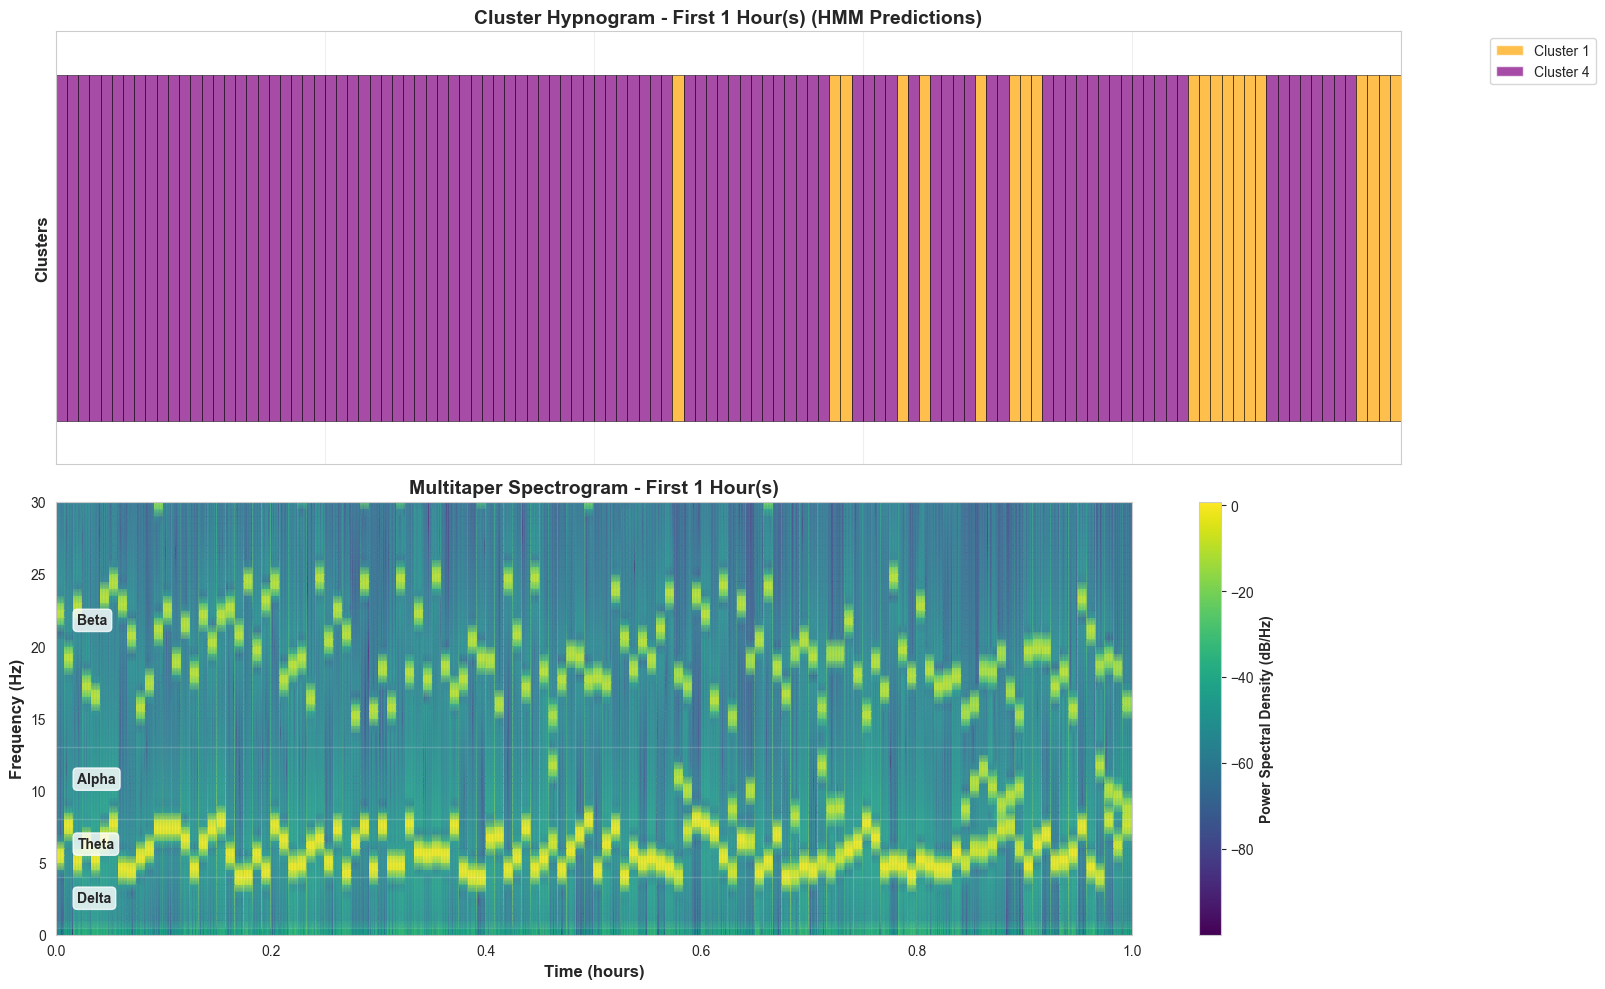

Visualization complete! Showing first 1 hour(s) of 23.9 total hours.


In [23]:
# Create hypnogram and spectrogram visualization (first hour only)
def create_hypnogram_spectrogram(predictions, eeg_data, time_vec, fs, cluster_names, max_hours=1):
    """
    Create a comprehensive visualization with hypnogram and spectrogram (limited to first hour)
    """
    # Calculate indices for the first hour
    epoch_duration = 30  # seconds
    epochs_per_hour = 3600 // epoch_duration  # 120 epochs per hour
    max_epochs = min(len(epoch_clusters), epochs_per_hour * max_hours)
    
    # Limit EEG data to first hour
    samples_per_hour = fs * 3600 * max_hours
    max_samples = min(len(eeg_data), samples_per_hour)
    
    # Subset the data
    predictions_subset = epoch_clusters[:max_epochs]
    eeg_subset = eeg_data[:max_samples]
    time_subset = time_vec[:max_samples]
    
    print(f"Processing first {max_hours} hour(s) of data:")
    print(f"Epochs: {len(predictions_subset)} (out of {len(epoch_clusters)})")
    print(f"EEG samples: {len(eeg_subset)} (out of {len(eeg_data)})")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # Create time vector for hypnogram (in hours)
    hypno_time = np.arange(len(predictions_subset)) * epoch_duration / 3600  # Convert to hours
    
    # Plot hypnogram
    cluster_colors = {0: 'red', 1: 'orange', 2: 'green', 3: 'blue', 4: 'purple'}
    
    for i, cluster in enumerate(predictions_subset):
        color = cluster_colors.get(cluster, 'gray')
        ax1.barh(0, epoch_duration/3600, left=hypno_time[i], height=0.8, 
                color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Customize hypnogram
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_ylabel('Clusters', fontweight='bold', fontsize=12)
    ax1.set_title(f'Cluster Hypnogram - First {max_hours} Hour(s) (HMM Predictions)', fontweight='bold', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.set_yticks([])
    
    # Add legend for clusters
    legend_elements = []
    for cluster, color in cluster_colors.items():
        if cluster in np.unique(predictions_subset):
            cluster_name = cluster_names.get(cluster, f'Cluster {cluster}')
            legend_elements.append(plt.Rectangle((0,0),1,1, fc=color, alpha=0.7, label=cluster_name))
    ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # Create spectrogram using multitaper method (optimized for shorter data)
    print("Computing multitaper spectrogram for first hour...")
    # Use shorter segments for better time resolution but manageable computation
    nperseg = fs * 2  # 2-second windows (reduced from 4 seconds)
    noverlap = nperseg // 2
    
    frequencies, times, Sxx = signal.spectrogram(
        eeg_subset, fs, nperseg=nperseg, noverlap=noverlap, 
        window='hamming', scaling='density'
    )
    
    # Convert power to dB and limit frequency range
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    freq_mask = frequencies <= 30  # Focus on 0-30 Hz
    
    # Plot spectrogram
    times_hours = times / 3600  # Convert to hours
    im = ax2.pcolormesh(times_hours, frequencies[freq_mask], Sxx_db[freq_mask, :], 
                       shading='gouraud', cmap='viridis')
    
    ax2.set_ylabel('Frequency (Hz)', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Time (hours)', fontweight='bold', fontsize=12)
    ax2.set_title(f'Multitaper Spectrogram - First {max_hours} Hour(s)', fontweight='bold', fontsize=14)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Power Spectral Density (dB/Hz)', fontweight='bold')
    
    # Add frequency band annotations
    band_ranges = [(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 13, 'Alpha'), (13, 30, 'Beta')]
    for low, high, name in band_ranges:
        ax2.axhspan(low, high, alpha=0.1, color='white')
        ax2.text(0.02, (low + high) / 2, name, transform=ax2.get_yaxis_transform(), 
                fontweight='bold', fontsize=10, bbox=dict(boxstyle='round,pad=0.3', 
                facecolor='white', alpha=0.8))
    
    # Set x-axis limits to show only the processed time range
    ax1.set_xlim(0, max_hours)
    ax2.set_xlim(0, max_hours)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Visualization complete! Showing first {max_hours} hour(s) of {len(eeg_data)/fs/3600:.1f} total hours.")
    
    return fig

# Create the visualization (first hour only)
fig = create_hypnogram_spectrogram(predictions, eeg_data, time_vec, sampling_rate, cluster_names, max_hours=1)

=== CLUSTER TRANSITION ANALYSIS ===
Transition probability matrix (rows = from cluster, columns = to cluster):

From\To   Cluster 0 Cluster 1 Cluster 2 Cluster 3 Cluster 4
-----------------------------------------------------------
Cluster 0      0.606     0.000     0.237     0.000     0.157 
Cluster 1      0.000     0.912     0.000     0.065     0.023 
Cluster 2      0.012     0.000     0.941     0.046     0.000 
Cluster 3      0.000     0.123     0.138     0.740     0.000 
Cluster 4      0.022     0.039     0.000     0.000     0.939 


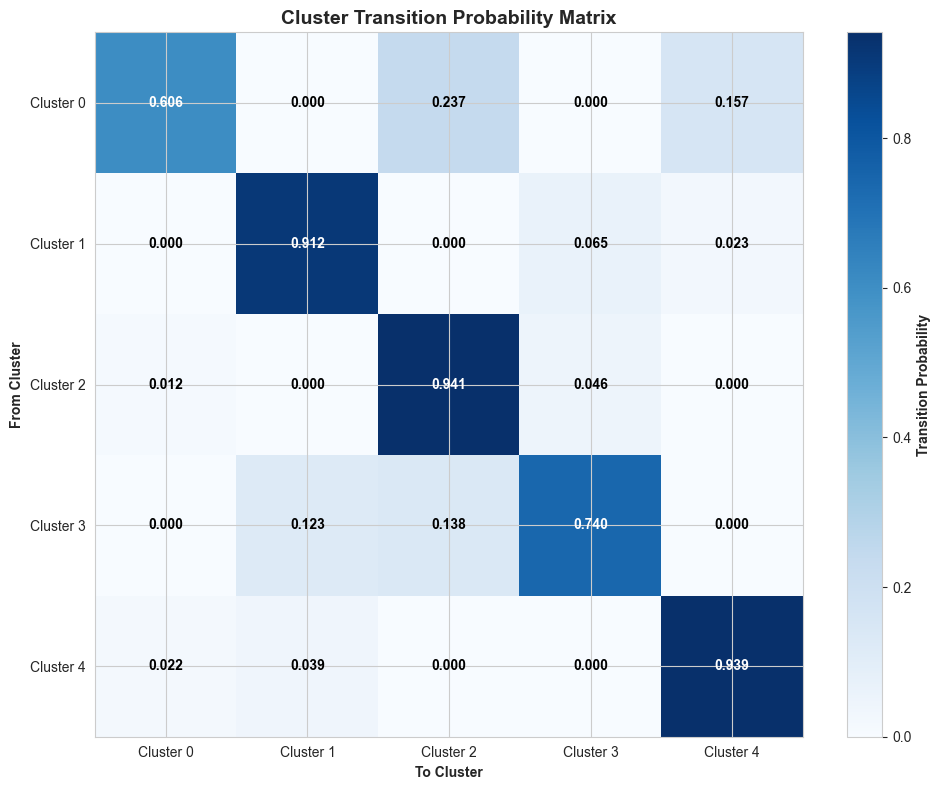

In [24]:
# Transition Matrix Analysis
def analyze_transition_matrix(predictions, cluster_names):
    """
    Analyze cluster transitions from HMM predictions
    """
    # Calculate transition matrix from predictions
    unique_clusters = sorted(np.unique(predictions))
    n_clusters = len(unique_clusters)
    transition_counts = np.zeros((n_clusters, n_clusters))
    
    for i in range(len(predictions) - 1):
        from_cluster = predictions[i]
        to_cluster = predictions[i + 1]
        from_idx = unique_clusters.index(from_cluster)
        to_idx = unique_clusters.index(to_cluster)
        transition_counts[from_idx, to_idx] += 1
    
    # Normalize to get probabilities
    transition_probs = transition_counts / (transition_counts.sum(axis=1, keepdims=True) + 1e-10)
    
    print("=== CLUSTER TRANSITION ANALYSIS ===")
    print("Transition probability matrix (rows = from cluster, columns = to cluster):\n")
    
    # Print header
    header = "From\\To  "
    for cluster in unique_clusters:
        header += f"{cluster_names.get(cluster, f'C{cluster}'):>10}"
    print(header)
    print("-" * len(header))
    
    # Print transition matrix
    for i, from_cluster in enumerate(unique_clusters):
        row = f"{cluster_names.get(from_cluster, f'C{from_cluster}'):>8}  "
        for j, to_cluster in enumerate(unique_clusters):
            row += f"{transition_probs[i, j]:>9.3f} "
        print(row)
    
    # Plot transition matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    
    im = ax.imshow(transition_probs, cmap='Blues', aspect='auto')
    
    # Set ticks and labels
    cluster_labels = [cluster_names.get(cluster, f'Cluster {cluster}') for cluster in unique_clusters]
    ax.set_xticks(range(n_clusters))
    ax.set_yticks(range(n_clusters))
    ax.set_xticklabels(cluster_labels)
    ax.set_yticklabels(cluster_labels)
    
    # Add text annotations
    for i in range(n_clusters):
        for j in range(n_clusters):
            text = ax.text(j, i, f'{transition_probs[i, j]:.3f}',
                          ha="center", va="center", color="black" if transition_probs[i, j] < 0.5 else "white",
                          fontweight='bold')
    
    ax.set_title('Cluster Transition Probability Matrix', fontsize=14, fontweight='bold')
    ax.set_xlabel('To Cluster', fontweight='bold')
    ax.set_ylabel('From Cluster', fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Transition Probability', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return transition_probs, unique_clusters

# Analyze transitions
transition_probs, unique_clusters = analyze_transition_matrix(predictions, cluster_names)

## Summary and Conclusions

This comprehensive analysis of the HMM results provides insights into cluster dynamics and temporal patterns in the data.

## Print Analysis Results

Generate comprehensive textual summaries of all analyses for easy interpretation and reporting.